# Security Evaluation

How can the security of a machine learning model be truly evaluated?  
Is one single $\epsilon$ enough?

To test robustness the ML with only one $\epsilon$ is NOT enough (can not say it is secure for all)  
Necessity to test robustness with different values of $\epsilon$ (big will corrupt all the datas)

In this notebook, you will use SecML to implement adversarial attacks against a given neural network (very simple), and we will reason on its robustness.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fabiogueunige/Trustworthy/blob/HEAD/02-SecurityEvaluations.ipynb)

### Always consider
* $\epsilon$ values matter -> too few of them not tell anything about the model  
* Attack may not converge because miss configured (empirical process)
* Security evaluation higly depend on test set datas (more we have better it is)

**ALWAYS USE ALL THE TEST SAMPLES**

In [12]:
# libnrary we want to use for doing attack, avoiding to write thinks wrote before again and again
try:
    import secml
except ImportError:
    %pip install git+https://github.com/pralab/secml
    %pip install foolbox

In [13]:
import torch
from torch import nn
from torch import optim
from secml.ml.classifiers import CClassifierPyTorch

random_state = 999


# creation of the multiclass classifier
class Net(nn.Module):
    def __init__(self, n_features, n_hidden, n_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


n_features = 2
n_classes = 3

# torch model creation
net = Net(n_features=n_features, n_classes=n_classes, n_hidden=100)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# wrap torch model in CClassifierPyTorch class
clf = CClassifierPyTorch(model=net,
                         loss=loss_function,
                         optimizer=optimizer,
                         input_shape=(n_features,),
                         random_state=random_state)

In [14]:
# create a classifier and training it
n_features = 2  # number of features
n_samples = 1250  # number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # centers of the clusters
cluster_std = 0.8  # standard deviation of the clusters
n_classes = len(centers)  # number of classes

from secml.data.loader import CDLRandomBlobs

dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # number of training set samples
n_ts = 250  # number of test set samples

# split in training and test
from secml.data.splitter import CTrainTestSplit

splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit(dataset.X).transform(tr.X)
ts.X = nmz.transform(ts.X)

In [15]:
# fitting the classifier
clf.fit(tr.X, tr.Y)
y_pred = clf.predict(ts.X)

from secml.ml.peval.metrics import CMetricAccuracy

accuracy = CMetricAccuracy().performance_score(y_true=ts.Y, y_pred=y_pred)
print("Accuracy on test set: {:.2%}".format(accuracy))


Accuracy on test set: 99.60%


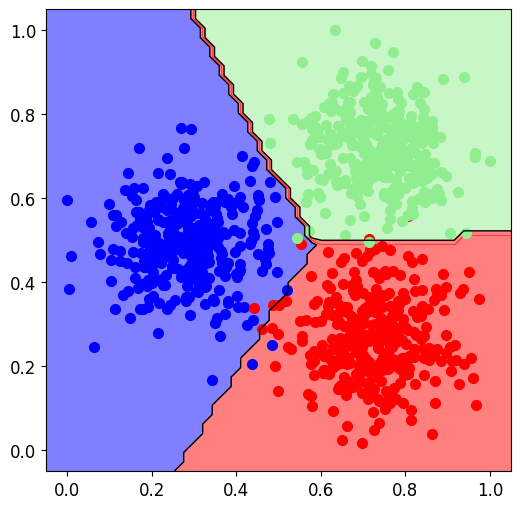

In [ ]:
# plot the classifier with the boundary and decicion regions
%matplotlib inline
from secml.figure import CFigure

fig = CFigure()
fig.sp.plot_ds(tr)
fig.sp.plot_decision_regions(clf, plot_background=True,
                             n_grid_points=50)
fig.show()

# Security Evaluations

Testing one single perturbation budget is not enough to understand the robustness of your machine learning classifier.
Hence, a fair analysis consists of a *security evaluation* of the model, by considering more perturbation budgets, and hence quantify the performance of the target systematically against stronger and stronger attacks.
To do so, we first set the number of parameters we want to test (in this case, `epsilons`) and we compute attacks by varying the perturbation size.

Attack with a L2 norm (circle)

In [ ]:
from secml.array import CArray
from secml.adv.attacks import CFoolboxPGDL2
from secml.ml.peval.metrics import CMetricAccuracy

# epsilons = CArray.linspace(0,2,4) # create list of epsilons to use in the security evaluation, modify only the last number for have more epsilon
# more epsilon, so the curve can be more precise and smooth 
epsilons = CArray.linspace(0,2,10) # create list of epsilons to use in the security evaluation, modify only the last number for have more epsilon
robust_accuracies = []
metric = CMetricAccuracy()
X, y = ts.X[:30, :], ts.Y[:30]

# keep the same attack for all the different epsilon
for eps in epsilons:  # create some different epsilon, es in immage corresponding on how many piuxel I want to tpuch for my attack
    pgd_attack = CFoolboxPGDL2(clf, None, # create a L2 attach, euclidean distance attack
                           lb=0, ub=1,
                           epsilons=eps, 
                           abs_stepsize=0.05, # step size of the attack
                           # steps=5, # number of steps of the attack
                           steps=25,
                           random_start=False)
    y_adv_pred, _, _, _ = pgd_attack.run(X,y) # TODO: run the attack on the X, y set of samples
    accuracy = metric.performance_score(y, y_adv_pred)
    robust_accuracies.append(accuracy)

Now plot the accuracy for all the epsilon used in the attack:  
* 0 eps than no attack, max accuracy  
* Then accuracy goes down   
Need very very little noise to put down accuracy of the model

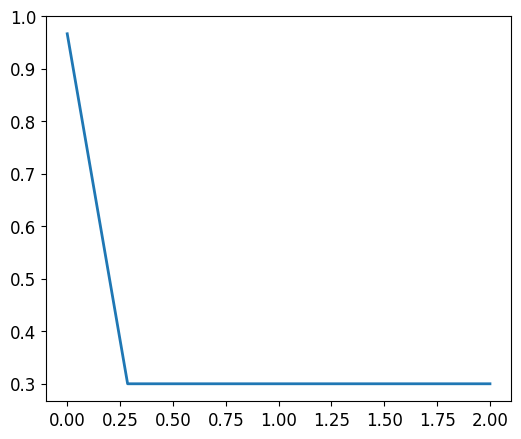

In [ ]:
# !! Perturbation function must be a decreasing monohonic function
from secml.figure import CFigure
# plot the robust accuracy, the robust of classifier under attack
# on y = robustness of the M.L. model
# on x = the perturbation in our attack
# after applying 0.75 perturbation, the adversary could missclassify the 70% of the point in original model
%matplotlib inline
fig = CFigure(height=5, width=6)
fig.sp.plot(epsilons, robust_accuracies)
fig.show()

### We have some problems: 
- Security evaluation highly depends on the test datas   
- Model bigger than will take hours per epsilon  
- Not happy because by increasing the size of the manipulation to infinity, the attack is not able to evade (not able to reach full missclassification)  
The attack is failing because with $\alpha$ small and not enough step size i will not have enough computation:  
* $\alpha$ small -> never reaching the minima
* $\alpha$ big -> skip the minimas

Possible solution:  
~ Than fix $\alpha$ small and increase the steps number  
This could take a lot of time  
~  

Attack will success only when $\alpha$ is large enough, so questions:  
* Sampling enough $\epsilon$ for my domain?  
* Attack is correctly instatiated?  
* What happen if i don't have enough sample data? -> security evaluation can change, but don't know how    

!! Security Evaluation depends on the test datas !!


Attack all points wih the square of $\epsilon$ because using LInf norm

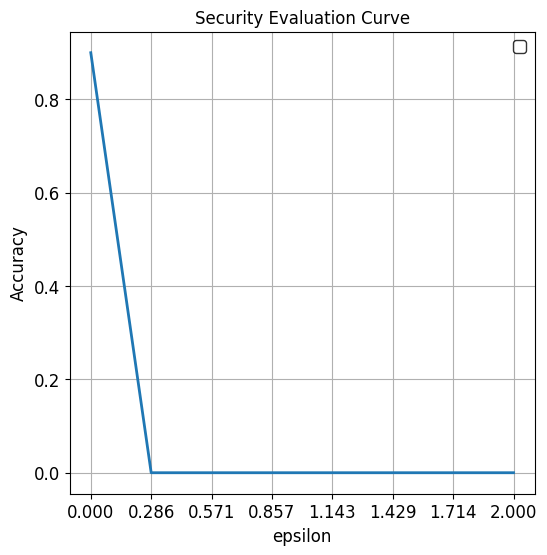

In [ ]:
# tool for evaluate the evaluation instead of starting from sketch every time
from secml.adv.seceval import CSecEval

# try to attack with l infinite norm, so inport the attack from library
from secml.adv.attacks import CFoolboxPGDLinf

# create a smaller dataset to try the infinite norm
# import the CDataset for create a smaller ts dataset
from secml.data import CDataset

small_ts = CDataset(ts.X[:10, :], ts.Y[:10]) # used only for speed up the code

pgd_attack = CFoolboxPGDLinf(clf, None,
                           lb=0, ub=1,
                           epsilons=0,
                           abs_stepsize=0.05,
                           # steps=20,
                           steps=10,
                           random_start=False)
# This line better for security evaluation
sec_eval = CSecEval(pgd_attack, param_name='epsilon', param_values=epsilons)
sec_eval.run_sec_eval(ts) # use always all the test set for evaluate teh model, small dataset used only for speed-uo the code (but wrong)

%matplotlib inline
fig = CFigure()
fig.sp.plot_sec_eval(sec_eval.sec_eval_data)
fig.show()